In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.sparse as sp
from cupyx.scipy.sparse.linalg import gmres
from scipy.sparse.linalg import cg
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as scp
np.set_printoptions(linewidth=300, precision=3)

from qmat import QDELTA_GENERATORS

from pySDC.core.collocation import CollBase
from pySDC.implementations.problem_classes.HeatEquation_ND_FD import heatNd_unforced
from pySDC.implementations.problem_classes.AllenCahn_2D_FD import allencahn_fullyimplicit
from pySDC.implementations.problem_classes.GeneralizedFisher_1D_FD_implicit import generalized_fisher
from pySDC.implementations.problem_classes.Auzinger_implicit import auzinger

class counter(object):
    def __init__(self, disp=False):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            # print('iter %3i\trk = %s' % (self.niter, str(rk)))
            print('   LIN: %3i' % self.niter)
    def get_iter(self):
        return self.niter

In [2]:
def nonlinear_sdc_cahn(dt = 0.0005, num_nodes = 4, nvars = (64, 64), nu = 2, eps=0.04, const_inner_iteration = False,
                  outer_abs_tol = 1E-14, inner_abs_tol = 1E-14, rel_tol = 1E-12, k_max = 10_000, n_max = 10_000):
    # instantiate problem
    prob = allencahn_fullyimplicit(nvars=nvars, nu = nu, eps = eps)

    coll = CollBase(num_nodes=num_nodes, tleft=0, tright=1, node_type='LEGENDRE', quad_type='RADAU-RIGHT')

    generator = QDELTA_GENERATORS['MIN-SR-S'](
        # for algebraic types (LU, ...)
        Q=coll.generator.Q,
        # for MIN in tables, MIN-SR-S ...
        nNodes=coll.num_nodes,
        nodeType=coll.node_type,
        quadType=coll.quad_type,
        # for time-stepping types, MIN-SR-NS
        nodes=coll.nodes,
        tLeft=coll.tleft,
    )
    QDmat = cp.asarray(generator.genCoeffs(k=None))


    # shrink collocation matrix: first line and column deals with initial value, not needed here
    Q = cp.asarray(coll.Qmat[1:, 1:])

    u0 = cp.asarray(prob.u_exact(t=0).flatten())
    # fill in u0-vector as right-hand side for the collocation problem
    u0_coll = cp.kron(cp.ones(coll.num_nodes), u0)

    nvars = prob.nvars[0] * prob.nvars[1]

    uk = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    fk = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    rhs = cp.zeros(nvars * coll.num_nodes, dtype='float64')

    ksum = 0
    nsum = 0
    timepoints = cp.arange(0, 0.01+dt, step=dt)
    u_buffer = cp.empty((len(timepoints), nvars))
    conv_buffer = cp.zeros(len(timepoints)) # marks the iteration, reaching the disered tolerances
    conv_buffer[0] = 1
    u_buffer[0, :] = u0

    #count = counter()
    for index, timepoint in enumerate(timepoints[:-1]):
        k = 0
        #print(timepoint)
        while k < k_max:
            # eval rhs
            for m in range(coll.num_nodes):
                fk[m * nvars: (m + 1) * nvars] = cp.asarray(prob.eval_f(uk[m * nvars: (m + 1) * nvars].get(),
                                                             t=timepoint + dt * coll.nodes[m]).flatten())
    
            resnorm = cp.linalg.norm(u0_coll - (uk - dt * sp.kron(Q, sp.eye(nvars)).dot(fk)), cp.inf)
            #print('SDC:', k, ksum, resnorm)
            if resnorm < outer_abs_tol and resnorm/cp.linalg.norm(u0_coll, cp.inf) < rel_tol:
                conv_buffer[index+1] = 1 # this iteration converged
                break
    
            g = cp.zeros(nvars * coll.num_nodes, dtype='float64')
            vn = uk
            fn = cp.zeros(nvars * coll.num_nodes, dtype='float64')
            n = 0
            while n < n_max:
                for m in range(coll.num_nodes):
                    fn[m * nvars: (m + 1) * nvars] = cp.asarray(prob.eval_f(vn[m * nvars: (m + 1) * nvars].get(),
                                                                 t=timepoint + dt * coll.nodes[m]).flatten())
                g[:] = u0_coll + dt * sp.kron(Q-QDmat, sp.eye(nvars)).dot(fk) - (vn - dt * sp.kron(QDmat, sp.eye(nvars)).dot(fn))
    
                # if g is close to 0, then we are done
                res_newton = cp.linalg.norm(g, cp.inf)
                rel_err = cp.linalg.norm(vn-uk, cp.inf) 
                #print('  Newton:', n, res_newton)
                n += 1
                nsum += 1
                if res_newton < inner_abs_tol and not const_inner_iteration and rel_err < rel_tol * cp.linalg.norm(vn, cp.inf):
                    break
    
                # assemble dg
                dg = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * vn ** prob.nu), offsets=0))
    
                # Newton
                # vk =  sp.linalg.spsolve(dg, g)
                vn -= gmres(dg, g, x0=cp.zeros_like(vn), maxiter=1000, atol=inner_abs_tol)[0]
    
            uk = vn.copy()
    
            k += 1
            ksum += 1
        temp = uk[-nvars:]
        u_buffer[index+1, :] = temp
        u0_coll = cp.kron(cp.ones(coll.num_nodes), temp).flatten()

    return u_buffer, timepoints, prob, ksum, nsum, conv_buffer

In [3]:
%%time
u1, t1, prob, ksum, nsum, conv_buffer = nonlinear_sdc_cahn(dt=0.0005, num_nodes = 3, nvars=(64, 64), inner_abs_tol=1E-12, outer_abs_tol=1E-12, n_max=5)
print((ksum, nsum))
cp.linalg.norm(u1[-1]-cp.asarray(prob.u_exact(t1[-1]).flatten()), np.inf)

(247, 588)
CPU times: user 5.93 s, sys: 214 ms, total: 6.15 s
Wall time: 6.7 s


array(4.20514032e-09)

In [8]:
dts_allen = 5/cp.logspace(3, 5, num=5)
print(dts_allen)
norms_allen = cp.empty(len(dts_allen))

for index, dt in enumerate(dts_allen):
    print("loop index: " + str(dt))
    u, t, prob, ksum, nsum, conv_buffer= nonlinear_sdc_cahn(dt = float(dt), num_nodes = 4, outer_abs_tol=1E-14, inner_abs_tol=1E-14)
    u_exact_allen =cp.asarray(prob.u_exact(t[-1]))
    norms_allen[index] = cp.max(cp.abs(u[-1] - u_exact_allen.flatten()))

[5.00000000e-03 1.58113883e-03 5.00000000e-04 1.58113883e-04
 5.00000000e-05]
loop index: 0.005
loop index: 0.0015811388300841895
loop index: 0.0005
loop index: 0.00015811388300841897
loop index: 5e-05


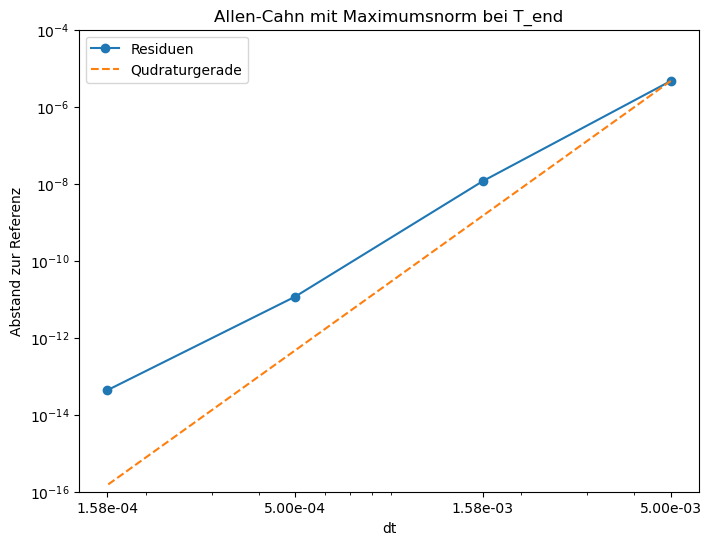

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
conv_line = cp.power(dts_allen[:-1], 7) * norms_allen[0]/np.power(dts_allen[0], 7)
ax.plot(dts_allen[:-1].get(), norms_allen[:-1].get(), marker = "o", label="Residuen")
ax.plot(dts_allen[:-1].get(), conv_line.get(), linestyle="dashed", label="Qudraturgerade")
ax.set_xscale("log", base = 10)
ax.set_xticks(dts_allen[:-1].get(), labels=["{:.2e}".format(dt) for dt in dts_allen[:-1].get()])
ax.set_yscale("log", base = 10)
ax.set_ylim(1E-16, 1E-4)
plt.xlabel("dt")
plt.ylabel("Abstand zur Referenz")
plt.legend()
ax.set_title("Allen-Cahn mit Maximumsnorm bei T_end")
plt.savefig("allencahn_maximumsnorm.png")

# Newton-SDC

In [3]:
def nonlinear_cahn(dt = 0.0005, num_nodes = 4, nvars = (64, 64), nu = 2, eps=0.04, const_inner_iteration = False, 
                  outer_abs_tol = 1E-14, inner_abs_tol = 1E-14, rel_tol = 1E-12, k_max = 10_000, n_max = 10_000):
    # instantiate problem
    prob = allencahn_fullyimplicit(nvars=nvars, nu = nu, eps = eps)

    coll = CollBase(num_nodes=num_nodes, tleft=0, tright=1, node_type='LEGENDRE', quad_type='RADAU-RIGHT')

    generator = QDELTA_GENERATORS['MIN-SR-S'](
        # for algebraic types (LU, ...)
        Q=coll.generator.Q,
        # for MIN in tables, MIN-SR-S ...
        nNodes=coll.num_nodes,
        nodeType=coll.node_type,
        quadType=coll.quad_type,
        # for time-stepping types, MIN-SR-NS
        nodes=coll.nodes,
        tLeft=coll.tleft,
    )
    QDmat = cp.asarray(generator.genCoeffs(k=None))

    # shrink collocation matrix: first line and column deals with initial value, not needed here
    Q = cp.asarray(coll.Qmat[1:, 1:])

    # c = coll.nodes
    # V = cp.fliplr(cp.vander(c))
    # C = cp.diag(c)
    # R = cp.diag([1 / i for i in range(1,coll.num_nodes+1)])
    # print(C @ V @ R @ cp.linalg.inv(V) - Q)
    # exit()


    u0 = cp.asarray(prob.u_exact(t=0).flatten())
    # fill in u0-vector as right-hand side for the collocation problem
    u0_coll = cp.kron(cp.ones(coll.num_nodes), u0)

    nvars = prob.nvars[0] * prob.nvars[1]

    un = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    fn = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    g = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    # vk = cp.zeros(nvars * coll.num_nodes, dtype='float64')

    ksum = 0
    nsum = 0
    timepoints = cp.arange(0, 0.01+dt, step=dt)
    u_buffer = cp.empty((len(timepoints), nvars))
    u_buffer[0, :] = u0
    #count = counter()
    
    for index, timepoint in enumerate(timepoints[:-1]):
        n = 0
        while n < n_max:
            # form the function g with g(u) = 0
            for m in range(coll.num_nodes):
                fn[m * nvars: (m + 1) * nvars] = cp.asarray(prob.eval_f(un[m * nvars: (m + 1) * nvars].get(),
                                                             t=timepoint + dt * coll.nodes[m]).flatten())
            g[:] = u0_coll - (un - dt * sp.kron(Q, sp.eye(nvars)).dot(fn))
    
            # if g is close to 0, then we are done
            res_newton = cp.linalg.norm(g, cp.inf)
            #print('Newton:', n, res_newton)
    
            if res_newton < outer_abs_tol: # and res_newton/cp.linalg.norm(u0_coll, cp.inf) < rel_tol:
                break
    
            # assemble dg
            dg = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(Q, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))

    
            # Newton
            # vk =  sp.linalg.spsolve(dg, g)
            # vk = sp.linalg.gmres(dg, g, x0=cp.zeros_like(vk), maxiter=10, atol=1E-10, callback=count)[0]
            # iter_count += count.niter
            # un -= vk
            # continue
    
            # Collocation
            # Emulate Newton
            # dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(Q, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))
            # Linear SDC (e.g. with diagonal preconditioner)
            dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un ** prob.nu), offsets=0))
            # Linear SDC with frozen Jacobian
            #dgP = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.csr_matrix(prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un[0:nvars] ** prob.nu), offsets=0))
            # dgP = dgP.astype('float64')
    
            # Diagonalization
            # D, V = cp.linalg.eig(Q)
            # Vinv = cp.linalg.inv(V)
            # dg_diag = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(sp.diags(D), prob.A + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * un[0:nvars] ** prob.nu), offsets=0))
            # dg_diag = dg_diag.astype('complex64')
    
            vk = cp.zeros(nvars * coll.num_nodes, dtype='float64') #un.copy() #
            res = cp.zeros(nvars * coll.num_nodes, dtype='float64')
    
            res[:] = g - dg.dot(vk)
            k = 0
            while k < k_max:
                # Newton/Collocation: works well with float32 for both P and res, but not for vk
                # vk += sp.linalg.spsolve(dgP, res)
                vk += sp.linalg.gmres(dgP, res, x0=cp.zeros_like(res), maxiter=100, atol=inner_abs_tol)[0]
    
                # Newton/Diagonalization
                # vk += cp.real(sp.kron(V,sp.eye(nvars)).dot(sp.linalg.spsolve(dg_diag, sp.kron(Vinv,sp.eye(nvars)).dot(res))))
                # vk += cp.real(sp.kron(V,sp.eye(nvars)).dot(sp.linalg.gmres(dg_diag, sp.kron(Vinv,sp.eye(nvars)).dot(res), x0=cp.zeros_like(res), maxiter=1, atol=1E-10, callback=count)[0]))
    
                res[:] = g - dg.dot(vk)
                resnorm = cp.linalg.norm(res, cp.inf)
                rel_err = cp.linalg.norm(vk-un, cp.inf)
                #print('   SDC:', n, k, ksum, resnorm)
    
                k += 1
                ksum += 1
                if resnorm < inner_abs_tol and not const_inner_iteration: #and rel_err < rel_tol * cp.linalg.norm(vk, cp.inf):
                    break
    
            # Update
            un -= vk
    
            # increase Newton iteration count
            n += 1
            nsum += 1
        temp = un[-nvars:]
        u_buffer[index+1, :] = temp
        u0_coll = cp.kron(cp.ones(coll.num_nodes), temp).flatten()

    return u_buffer, timepoints, prob, ksum, nsum

In [13]:
res_c, time_c, prob_c, ksum, nsum = nonlinear_cahn(dt=0.001, num_nodes=4, outer_abs_tol=1E-14, inner_abs_tol=1E-14)
print((ksum, nsum))
cp.linalg.norm(res_c[-1]-cp.asarray(prob_c.u_exact(time_c[-1]).flatten()), cp.inf)

(3443, 43)


array(7.54147855e-10)

In [4]:
dts_allen = 1/cp.logspace(3, 4, num = 4)
print(dts_allen)
norms_allen = cp.empty(len(dts_allen))

for index, dt in enumerate(dts_allen):
    print("loop index: " + str(dt))
    u, t, prob, ksum, nsum= nonlinear_cahn(dt = float(dt), num_nodes = 4, outer_abs_tol=1E-14, inner_abs_tol=1E-14)
    u_exact_allen =cp.asarray(prob.u_exact(t[-1]))
    norms_allen[index] = cp.max(cp.abs(u[-1] - u_exact_allen.flatten()))

[0.001      0.00046416 0.00021544 0.0001    ]
loop index: 0.001
loop index: 0.0004641588833612778
loop index: 0.00021544346900318845
loop index: 0.0001


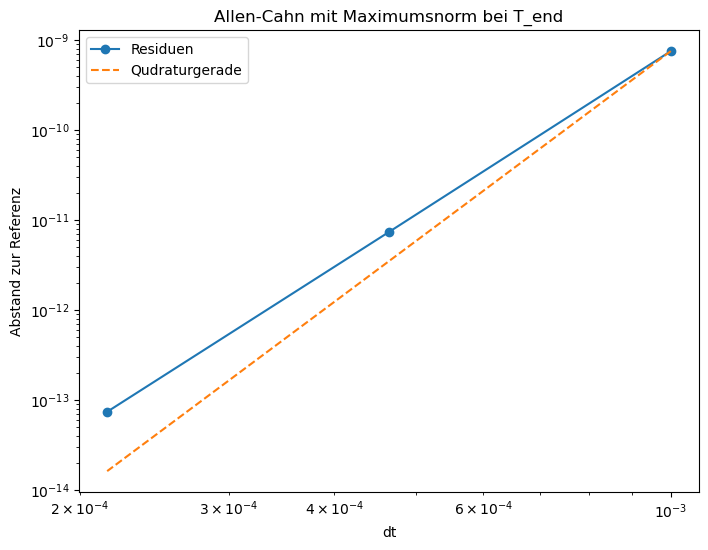

In [5]:
fig = plt.figure(figsize=(8, 6))
conv_line = cp.power(dts_allen[:-1], 7) * norms_allen[0]/np.power(dts_allen[0], 7)
plt.plot(dts_allen[:-1].get(), norms_allen[:-1].get(), marker = "o", label="Residuen")
plt.plot(dts_allen[:-1].get(), conv_line.get(), linestyle="dashed", label="Qudraturgerade")
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
#plt.ylim(1E-15, 1E-8)
plt.xlabel("dt")
plt.ylabel("Abstand zur Referenz")
#plt.xticks(dts_allen[:-1].get(), labels=["{:.2e}".format(dt) for dt in dts_allen[:-1].get()])
plt.legend()
plt.title("Allen-Cahn mit Maximumsnorm bei T_end")
plt.savefig("allencahn_maximumsnorm_newsdc.png")
plt.show()

In [6]:
data = cp.empty((5, 4))
dt = 5E-4
for maxIter in range(1, len(data)+1):
    print(maxIter)
    nsum_snf = nonlinear_sdc_cahn(dt=dt, num_nodes =3, outer_abs_tol=1E-14, inner_abs_tol=1E-14, n_max=maxIter, nvars=(64, 64))[4]
    sdcsum_nsf = nonlinear_cahn(dt=dt, num_nodes=3, outer_abs_tol = 1E-14, inner_abs_tol=1E-14, k_max=maxIter, nvars=(64, 64))[3]
    nsum_snf_const = nonlinear_sdc_cahn(dt=dt, num_nodes =3, outer_abs_tol=1E-14, inner_abs_tol=1E-14, n_max=maxIter, nvars=(64, 64), const_inner_iteration=True)[4]
    sdcsum_nsf_const = nonlinear_cahn(dt=dt, num_nodes=3, outer_abs_tol = 1E-14, inner_abs_tol=1E-14, k_max=maxIter, nvars=(64, 64), const_inner_iteration=True)[3]

    data[maxIter-1] = cp.r_[nsum_snf, sdcsum_nsf, nsum_snf_const, sdcsum_nsf_const]

1
2
3
4
5


In [43]:
data

array([[ 306.,  306.,  306.,  306.],
       [ 610.,  341.,  610.,  356.],
       [ 735.,  365.,  915.,  366.],
       [ 775.,  386., 1220.,  408.],
       [ 776.,  409., 1525.,  410.]])

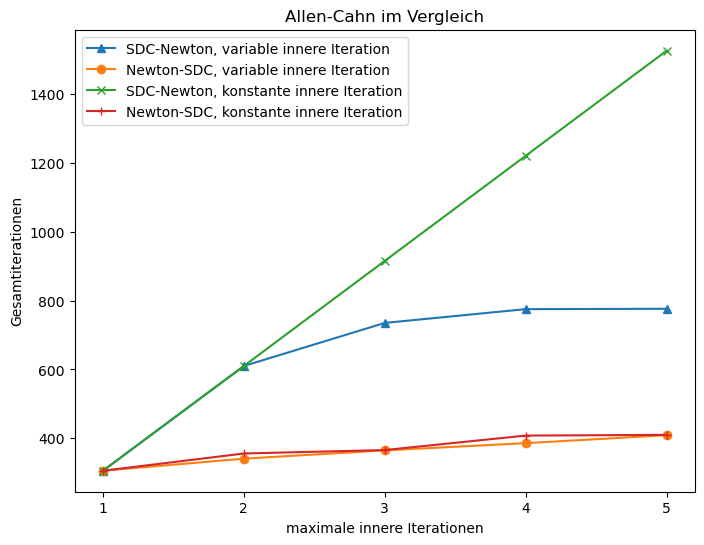

In [7]:
plt.figure(figsize=(8, 6))
plt.title("Allen-Cahn im Vergleich")
axis = np.arange(1, 6)
plt.plot(axis, data[::, 0].get(), label="SDC-Newton, variable innere Iteration", marker="^")
plt.plot(axis, data[::, 1].get(), label="Newton-SDC, variable innere Iteration", marker="o")
plt.plot(axis, data[::, 2].get(), label="SDC-Newton, konstante innere Iteration", marker="x")
plt.plot(axis, data[::, 3].get(), label="Newton-SDC, konstante innere Iteration", marker="+")
plt.xticks(axis, labels =["{}".format(dt) for dt in axis]) 
plt.xlabel("maximale innere Iterationen")
plt.ylabel("Gesamtiterationen")
plt.legend()
plt.savefig("allencahnvergleich.png")
plt.show()

In [16]:
columns = ["method", "problem","tol", "dt", "quad_nodes", "nvars", "new_max", "sdc_sum", "new_sum", "norm"]
table = pd.DataFrame(columns=columns)

for dt in [0.0005, 0.00005]:
    for quadn in [2, 3, 4, 5]:
        for nvars in [(64, 64), (128, 128), (256, 256)]:
            for niter in [1, 2, 3, 5, 10, 20]:
                print((dt, quadn, nvars, niter))
                u1, t1, prob, ksum, nsum, conv_buffer = nonlinear_sdc_cahn(dt=dt, num_nodes = quadn, nvars=nvars, n_max=niter, outer_abs_tol = 1E-12, inner_abs_tol=1E-12)
                max_norm = cp.linalg.norm(u1[-1]-cp.asarray(prob.u_exact(t1[-1]).flatten()), np.inf)
                row = ["sdc_newton", "allencahn", 1E-12, dt, quadn, nvars, niter, ksum, nsum, max_norm.get()]
                table.loc[len(table.index)] = row

table

(0.0005, 2, (64, 64), 1)
(0.0005, 2, (64, 64), 2)
(0.0005, 2, (64, 64), 3)
(0.0005, 2, (64, 64), 5)
(0.0005, 2, (64, 64), 10)
(0.0005, 2, (64, 64), 20)
(0.0005, 2, (128, 128), 1)
(0.0005, 2, (128, 128), 2)
(0.0005, 2, (128, 128), 3)
(0.0005, 2, (128, 128), 5)
(0.0005, 2, (128, 128), 10)
(0.0005, 2, (128, 128), 20)
(0.0005, 2, (256, 256), 1)
(0.0005, 2, (256, 256), 2)
(0.0005, 2, (256, 256), 3)
(0.0005, 2, (256, 256), 5)
(0.0005, 2, (256, 256), 10)
(0.0005, 2, (256, 256), 20)
(0.0005, 3, (64, 64), 1)
(0.0005, 3, (64, 64), 2)
(0.0005, 3, (64, 64), 3)
(0.0005, 3, (64, 64), 5)
(0.0005, 3, (64, 64), 10)
(0.0005, 3, (64, 64), 20)
(0.0005, 3, (128, 128), 1)
(0.0005, 3, (128, 128), 2)
(0.0005, 3, (128, 128), 3)
(0.0005, 3, (128, 128), 5)
(0.0005, 3, (128, 128), 10)
(0.0005, 3, (128, 128), 20)
(0.0005, 3, (256, 256), 1)
(0.0005, 3, (256, 256), 2)
(0.0005, 3, (256, 256), 3)
(0.0005, 3, (256, 256), 5)
(0.0005, 3, (256, 256), 10)
(0.0005, 3, (256, 256), 20)
(0.0005, 4, (64, 64), 1)
(0.0005, 4, (64

,method,problem,tol,dt,quad_nodes,nvars,new_max,sdc_sum,new_sum,norm
0,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",1,207,207,2.2793413507748994e-06
1,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",2,205,410,2.2793417274735717e-06
2,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",3,205,492,2.2793417259192594e-06
3,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",5,205,514,2.2793417259192594e-06
4,sdc_newton,allencahn,1.000000e-12,0.00050,2,"(64, 64)",10,205,515,2.2793417259192594e-06
...,...,...,...,...,...,...,...,...,...,...
139,sdc_newton,allencahn,1.000000e-12,0.00005,5,"(256, 256)",2,1052,2104,2.4666380049609415e-12
140,sdc_newton,allencahn,1.000000e-12,0.00005,5,"(256, 256)",3,1052,2462,2.4665824938097103e-12
141,sdc_newton,allencahn,1.000000e-12,0.00005,5,"(256, 256)",5,1052,2463,2.4665824938097103e-12
142,sdc_newton,allencahn,1.000000e-12,0.00005,5,"(256, 256)",10,1052,2463,2.4665824938097103e-12


In [17]:
table.to_csv("sdcnew_allencahn_table.csv")